<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final_modulo1_wstuff_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [ ]:
## Get dataset images

!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip "/content/train2017.zip"
!unzip "/content/val2017.zip"

In [ ]:
## Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!unzip "/content/stuff_annotations_trainval2017.zip"


In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
dataDir='/content'

## Annotations from instances of objects train/val

aFile_inst_train='{}/annotations/instances_train2017.json'.format(dataDir) ## Annotation file - train
aFile_inst_val='{}/annotations/instances_val2017.json'.format(dataDir) ## Annotation file - validation

## Annotations from "stuff" train/val

aFile_stuff_train='{}/annotations/stuff_train2017.json'.format(dataDir) ## Annotation file - train
aFile_stuff_val='{}/annotations/stuff_val2017.json'.format(dataDir) ## Annotation file - validation

coco_inst_train = COCO(aFile_inst_train)
coco_inst_val = COCO(aFile_inst_val)

coco_stuff_train = COCO(aFile_stuff_train)
coco_stuff_val = COCO(aFile_stuff_val)

loading annotations into memory...
Done (t=19.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=19.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [4]:
# Check which GPU we are using
!nvidia-smi

Tue Jun 28 16:43:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Implementação do MyDataset

In [6]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.expand(3,-1,-1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco_inst, coco_stuff, file_dir: str, transformations, num_cats: int):
    self.img_ids = img_ids
    self.coco_inst = coco_inst
    self.coco_stuff = coco_stuff
    self.transformations = transformations
    self.num_cats = num_cats

    ## Inputs
    #imgs_info = self.coco.loadImgs(self.img_ids)
    #imgs_url = [imgs_info[i]['coco_url'] for i in tqdm.notebook.tqdm(range(len(imgs_info)))]
    img_ids_str = list(map(str, img_ids))
    imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
    self.inputs = imgs

    ## Targets
    targets = torch.tensor([])

    for id in tqdm.notebook.tqdm(img_ids):
      ann_id_inst = self.coco_inst.getAnnIds(id)
      ann_id_stuff = self.coco_stuff.getAnnIds(id)

      anns_inst = self.coco_inst.loadAnns(ann_id_inst)
      anns_stuff = self.coco_stuff.loadAnns(ann_id_stuff)
      anns = anns_inst + anns_stuff      

      cat_idxs = [anns[j]['category_id'] for j in range(len(anns))]
      tgt = torch.zeros(self.num_cats)
      tgt[cat_idxs] = 1
      tgt = tgt.unsqueeze(0)
      targets = torch.cat((targets, tgt), dim=0)
    
    self.targets = targets


  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [8]:
all_cat_ids = coco_inst_train.getCatIds() + coco_stuff_train.getCatIds()
num_cats = all_cat_ids[-1] + 1 #zero is included to facilitate index identification, even if there is no cat with id = '0'

#Assert do MyDataset

In [9]:
## Dataset

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset(img_ids=dummy_image_ids, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_input, first_batch_target = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_input = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_input = torch.cat((correct_first_batch_input, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_input = correct_first_batch_input.view(5, 3, 224, 224)
correct_first_batch_input = torch.FloatTensor(correct_first_batch_input)

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert do input do dataset')

## Verificação visual dos targets
#cats = [[4, 1, 2],
#       [1, 49, 61, 81],
#       [21, 28, 1],
#       [1, 74, 76, 72],
#       [72, 1, 74, 76]]
print(first_batch_target)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Passou no assert de tamanho do dataset.
Passou no assert do input do dataset
tensor([[0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [10]:
## Verificação de um item do batch do dataset (input e target)
dummy_dataset[4]

(tensor([[[ 2.1847,  2.1975,  2.2000,  ...,  1.5958,  1.7502,  1.7454],
          [ 2.1893,  2.2098,  2.2147,  ...,  1.2540,  1.6762,  1.7460],
          [ 2.2316,  2.2147,  2.1847,  ...,  1.0032,  1.5065,  1.6916],
          ...,
          [-1.7464, -1.7624, -1.7424,  ..., -0.6268, -0.9589, -1.1221],
          [-1.7592, -1.7769, -1.7632,  ..., -0.8117, -1.2109, -0.7916],
          [-1.7598, -1.7604, -1.7589,  ..., -1.1408, -0.9556, -0.5506]],
 
         [[ 2.3804,  2.3936,  2.3886,  ...,  0.7892,  0.8336,  0.7926],
          [ 2.3768,  2.3810,  2.3761,  ...,  0.5911,  0.8378,  0.8267],
          [ 2.3934,  2.3761,  2.3717,  ...,  0.4422,  0.7533,  0.8653],
          ...,
          [-1.6559, -1.6723, -1.6518,  ..., -0.7802, -1.1426, -1.3269],
          [-1.6690, -1.6871, -1.6731,  ..., -1.0211, -1.3536, -0.9635],
          [-1.6696, -1.6702, -1.6687,  ..., -1.3225, -1.1605, -0.7436]],
 
         [[ 2.4875,  2.5006,  2.4993,  ...,  0.5205,  0.4436,  0.4035],
          [ 2.4881,  2.5006,

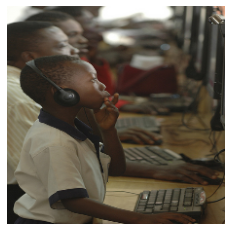

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}] 
 [{'supercategory': 'textile', 'id': 105, 'name': 'clothes'}, {'supercategory': 'furniture-stuff', 'id': 110, 'name': 'desk-stuff'}, {'supercategory': 'wall', 'id': 173, 'name': 'wall-other'}, {'supercategory': 'other', 'id': 183, 'name': 'other'}]


In [11]:
from torch.functional import cartesian_prod
## Verificação visual do dataset (imagem e categorias = targets)
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
img, cats = dummy_dataset[4]
cats = torch.nonzero(cats).squeeze().numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst = cats[cats <= 91]
cats_stuff = cats[cats > 91]

print(coco_inst_train.loadCats(cats_inst), '\n', coco_stuff_train.loadCats(cats_stuff))

# Carregamento do Dataset

In [12]:
##Número de exemplos do dataset
all_img_ids_train = coco_inst_train.getImgIds()
all_img_ids_val_test = coco_inst_val.getImgIds()

data_train_ex_num = len(all_img_ids_train)
data_valid_ex_num = int(len(all_img_ids_val_test) / 2) #validation coco dataset was divided in two sets, one being used as val and other as test (test set is not used in validation or training)
data_test_ex_num = int(len(all_img_ids_val_test) / 2)
all_ex_num = data_train_ex_num + data_valid_ex_num + data_test_ex_num

## Número de exemplos (truncado ou não)
train_ex_num = 50_000 #50_000
valid_ex_num = 2_500 #2_500
test_ex_num = 2_500 #2_500

max_lines = train_ex_num + valid_ex_num + test_ex_num

print(f"Number of examples used: {max_lines}; Number of examples in the dataset: {all_ex_num}")

## Carregamento do Dataset

img_ids_train = all_img_ids_train[:train_ex_num]
img_ids_val = all_img_ids_val_test[:valid_ex_num]
img_ids_test = all_img_ids_val_test[valid_ex_num:valid_ex_num + test_ex_num]

print(f"Train: {len(img_ids_train)}, Valid: {len(img_ids_val)}, Test: {len(img_ids_test)}")

valid_dataset = MyDataset(img_ids=img_ids_val, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
test_dataset = MyDataset(img_ids=img_ids_test, coco_inst=coco_inst_val, coco_stuff=coco_stuff_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
train_dataset = MyDataset(img_ids=img_ids_train, coco_inst=coco_inst_train, coco_stuff=coco_stuff_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)

Number of examples used: 55000; Number of examples in the dataset: 123287
Train: 50000, Valid: 2500, Test: 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

torch.Size([184])


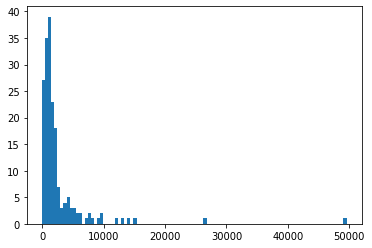

tensor([1.0000e+00, 8.7991e-01, 3.5928e+01, 8.9325e+00, 3.3990e+01, 4.5992e+01,
        2.9998e+01, 2.9469e+01, 1.9367e+01, 3.7081e+01, 2.7074e+01, 6.7871e+01,
        1.0000e+00, 6.7681e+01, 1.6622e+02, 2.0496e+01, 3.5232e+01, 2.7490e+01,
        2.5164e+01, 4.0152e+01, 8.4034e+01, 6.0652e+01, 5.6013e+01, 1.2787e+02,
        5.6737e+01, 4.6393e+01, 1.0000e+00, 2.0701e+01, 2.8976e+01, 1.0000e+00,
        1.0000e+00, 1.6599e+01, 3.1446e+01, 4.6125e+01, 5.2937e+01, 3.8463e+01,
        6.9621e+01, 2.7217e+01, 5.4127e+01, 5.1910e+01, 4.8950e+01, 3.6202e+01,
        3.0075e+01, 3.4436e+01, 1.2889e+01, 1.0000e+00, 4.5512e+01, 1.1830e+01,
        3.2025e+01, 2.6716e+01, 3.2422e+01, 1.5545e+01, 5.4741e+01, 7.9386e+01,
        4.6847e+01, 6.9822e+01, 5.7275e+01, 6.8832e+01, 9.0575e+01, 3.4162e+01,
        7.3405e+01, 4.0911e+01, 8.1625e+00, 2.5824e+01, 2.4826e+01, 3.0250e+01,
        1.0000e+00, 8.9721e+00, 1.0000e+00, 1.0000e+00, 3.2135e+01, 1.0000e+00,
        2.4394e+01, 3.2602e+01, 6.0805e+

In [13]:
## Obtendo pesos para balancear o dataset no treinamento
_, cats = train_dataset[:]
cats_num = cats.sum(dim=0)
print(cats_num.shape)

##Histograma mostrando a falta de balanceamento no dataset
plt.hist(cats_num, bins=100)
plt.show()

##Criação dos pesos (a serem utilizados na Loss)
#fórmula: número de contagens negativas / número de contagens positivas para cada classe
#https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
cats_positive_examples = cats_num
cats_negative_examples = (train_ex_num - cats_num)
cats_weights = cats_negative_examples / cats_positive_examples
cats_weights[cats_weights==float('inf')] = 1 #remove excessive weight for classes not included in the dataset, considering also index 0 in this case

pos_weight = cats_weights
pos_weight.to(device)

In [14]:
class MultiLabelClassifier(nn.Module):

    def __init__(self, num_cats, pos_weight):
        super().__init__()
        self.num_cats = num_cats
        self.pos_weight = pos_weight

        self.backbone = models.resnet50(pretrained=True)
        self.model_1_wo_fc = nn.Sequential(*(list(self.backbone.children())[:-1])).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=2048, out_features=num_cats),
            #nn.Sigmoid() - sigmoid removed to use BCEWithLogitsLoss()
        ).to(device)
    
    def forward(self, input):
        y_hat = self.model_1_wo_fc(input)
        y_hat = torch.flatten(y_hat, 1)
        y_hat = self.classifier(y_hat)

        return y_hat

#Teste do Modelo

In [15]:
model_1_test = MultiLabelClassifier(num_cats=num_cats, pos_weight=pos_weight)

sample_input, _ = next(iter(DataLoader(train_dataset)))
sample_output = model_1_test(sample_input.to(device))

print(f'sample_input.shape: {sample_input.shape}')
print(f'sample_output.shape: {sample_output.shape}')

num_params = sum(p.numel() for p in model_1_test.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

sample_input.shape: torch.Size([1, 3, 224, 224])
sample_output.shape: torch.Size([1, 184])
Number of model parameters: 25934048


#Laço de treinamento

In [15]:
max_examples = 5_000_000
eval_every_steps = 1000
lr = 6e-4

model_1 = MultiLabelClassifier(num_cats=num_cats, pos_weight=pos_weight)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=128)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

def train_step(inputs, targets):
    model_1.train()
    model_1.zero_grad()
    outputs = model_1(inputs)
    #outputs = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion_t = nn.BCEWithLogitsLoss(pos_weight=model_1.pos_weight)
    criterion_t.to(device)
    loss = criterion_t(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(inputs, targets):
    model_1.eval()
    outputs = model_1(inputs)
    #logits = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion_v = nn.BCEWithLogitsLoss()
    criterion_v.to(device)
    loss = criterion_v(outputs, targets)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input, train_target in tqdm.notebook.tqdm(train_loader):
        loss = train_step(train_input.to(device), train_target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)

            with torch.no_grad():
                valid_loss = np.average([
                    validation_step(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, valid loss: {valid_loss:.6f}')
            train_losses = []

        n_examples += len(train_input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

  0%|          | 0/390 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 1.353046, valid loss: 0.668801


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

1000 steps; 128000 examples so far; train loss: 0.675558, valid loss: 0.309876


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

2000 steps; 256000 examples so far; train loss: 0.545060, valid loss: 0.277261


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

3000 steps; 384000 examples so far; train loss: 0.459211, valid loss: 0.250197


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

4000 steps; 512000 examples so far; train loss: 0.402570, valid loss: 0.232782


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

5000 steps; 640000 examples so far; train loss: 0.356562, valid loss: 0.220881


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

6000 steps; 768000 examples so far; train loss: 0.315422, valid loss: 0.193784


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

7000 steps; 896000 examples so far; train loss: 0.289458, valid loss: 0.215352


  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Avaliação do módulo 1 (model_1) no dataset de teste

In [16]:
test_loader = DataLoader(test_dataset, batch_size=128)

with torch.no_grad():
    test_loss = np.average([
        validation_step(test_input.to(device), test_target.to(device))
        for test_input, test_target in test_loader
    ])

print(f'test loss: {test_loss}')

test loss: 0.1937408998608589


In [46]:
def accuracy_step(inputs, targets, threshold=0.90):
    model_1.eval()
    outputs = torch.sigmoid(model_1(inputs))
    outputs[outputs >= threshold] = 1.0
    n_correct = (outputs == targets).sum()
    accuracy = n_correct / targets.sum(dim=1) * 100

    return accuracy

tensor(5, device='cuda:0')
tensor([29.4118], device='cuda:0')


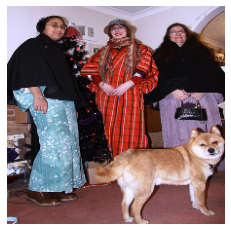

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}] 
 [{'supercategory': 'furniture-stuff', 'id': 98, 'name': 'cabinet'}, {'supercategory': 'raw-material', 'id': 100, 'name': 'cardboard'}, {'supercategory': 'floor', 'id': 101, 'name': 'carpet'}, {'supercategory': 'ceiling', 'id': 102, 'name': 'ceiling-other'}, {'supercategory': 'textile', 'id': 105, 'name': 'clothes'}, {'supercategory': 'floor', 'id': 117, 'name': 'floor-tile'}, {'supercategory': 'furniture-stuff', 'id': 123, 'name': 'furniture-other'}, {'supercategory': 'raw-material', 'id': 143, 'name': 'plastic'}, {'supercategory': 'textile', 'id': 167, 'name': 'textile-other'}, {'supercategory': 'plant', 'id': 169, 'name': 'tree'}, {'supercategory': 'wall', 'id': 171, 'name': 'wall-brick'}, {'supercategory': 'wall', 'id': 172, 'name': 'wall-concrete'}, {

array([ 18,  93, 101, 102, 152, 167, 183])

In [37]:
## Teste com exemplo de teste

inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])

index = random.randrange(test_ex_num)
img, cats = test_dataset[index]
inputs = img.unsqueeze(dim=0)
targets = cats.unsqueeze(dim=0)
accuracy = accuracy_step(inputs.to(device), targets.to(device))
print(accuracy)

## Image categories (random image from the test set)
cats = torch.nonzero(cats).squeeze(1).numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()

cats_inst = cats[cats <= 91]
cats_stuff = cats[cats > 91]
print(coco_inst_val.loadCats(cats_inst), '\n', coco_stuff_val.loadCats(cats_stuff))

## Image predicted categories
model_1.eval()
img = img.to(device)
img = img.unsqueeze(0)
cats_predicted = torch.sigmoid(model_1(img))
threshold = 0.90
cats_predicted[cats_predicted >= threshold] = 1
cats_predicted[cats_predicted < threshold] = 0
cats_predicted = cats_predicted.squeeze()
cats_predicted = torch.nonzero(cats_predicted).squeeze(1).cpu().numpy()
cats_predicted





In [47]:
for i in range(test_ex_num):
    img, cats = test_dataset[i]
    inputs = img.unsqueeze(dim=0)
    targets = cats.unsqueeze(dim=0)
    accuracy += accuracy_step(inputs.to(device), targets.to(device)) / test_ex_num
  
print(accuracy)

tensor([94.6713], device='cuda:0')


In [43]:
accuracy

tensor([0.0062], device='cuda:0')